In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, LogLocator
import pandas as pd
from scipy.interpolate import UnivariateSpline
import numpy as np

In [2]:
# Windhorst et al. 2023
windhorst_df = pd.read_csv('windhorst2023.csv') # Make sure you have this file in the same directory

In [3]:
windhorst_df

,mag,wave_0.153,wave_0.225,wave_0.356,wave_0.474,wave_0.631,wave_0.758,wave_0.883,wave_1.02,wave_1.25,wave_1.65,wave_2.15,wave_2.77,wave_3.54,wave_4.49
0,7.50,0.000002,0.000001,0.000007,4.942793e-05,1.216234e-03,0.000135,0.000146,1.862685e-04,2.444320e-04,2.546509e-04,1.665367e-04,3.456864,4.989246e-05,0.000021
1,7.51,0.000002,0.000001,0.000007,5.006923e-05,1.229015e-03,0.000136,0.000148,1.888277e-04,2.477808e-04,2.582382e-04,1.689721e-04,3.477715,5.061485e-05,0.000022
2,7.52,0.000002,0.000001,0.000007,5.071885e-05,1.241931e-03,0.000138,0.000150,1.914220e-04,2.511755e-04,2.618760e-04,1.714431e-04,3.498692,5.134770e-05,0.000022
3,7.53,0.000002,0.000001,0.000007,5.137690e-05,1.254982e-03,0.000140,0.000152,1.940520e-04,2.546167e-04,2.655651e-04,1.739503e-04,3.519796,5.209117e-05,0.000022
4,7.54,0.000002,0.000001,0.000007,5.204349e-05,1.268170e-03,0.000142,0.000154,1.967182e-04,2.581050e-04,2.693062e-04,1.764941e-04,3.541027,5.284539e-05,0.000023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,30.96,90033.516323,456470.331499,834433.635681,1.122963e+06,1.023564e+06,915924.484447,689278.586090,1.197895e+06,1.225102e+06,1.648079e+06,1.488937e+06,2808.040405,1.129466e+06,879554.187073
2347,30.97,90481.565264,459134.836892,838970.792439,1.128896e+06,1.027828e+06,919985.388994,691838.709115,1.203583e+06,1.230742e+06,1.656139e+06,1.496393e+06,2741.623910,1.134617e+06,883204.432965
2348,30.98,90931.843906,461814.895517,843532.619572,1.134861e+06,1.032110e+06,924064.298240,694408.340967,1.209298e+06,1.236409e+06,1.664238e+06,1.503886e+06,2676.778316,1.139792e+06,886869.827776
2349,30.99,91384.363346,464510.598161,848119.251224,1.140857e+06,1.036410e+06,928161.292014,696987.516961,1.215041e+06,1.242102e+06,1.672378e+06,1.511417e+06,2613.466465,1.144990e+06,890550.434376


In [4]:
mag = windhorst_df['mag']
N = windhorst_df['wave_2.15']

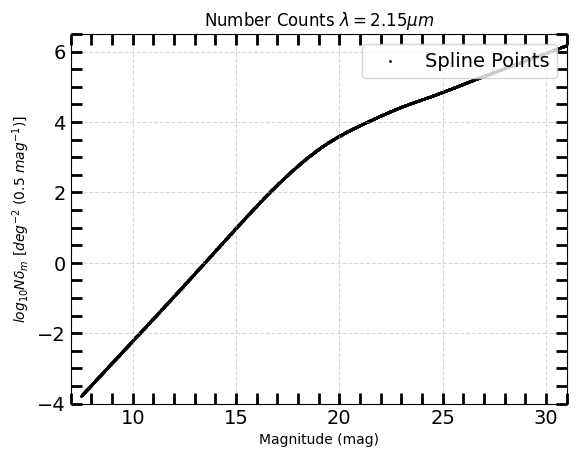

In [5]:
fig, ax1 = plt.subplots()
ax1.scatter(mag, np.log10(N), color='k', label='Spline Points',s=1)
plt.xlabel('Magnitude (mag)')
plt.ylabel(r'$log_{10}N \delta_m$ [$deg^{-2}$ (0.5 $mag^{-1}$)]')
plt.title(r'Number Counts $\lambda=2.15\mu m$')
plt.grid(linestyle='--',alpha=0.5)
ax1.tick_params(axis='both', right=True, top=True, width=2, length=8, direction='in', which='both', labelsize=14) #Inward pointing ticks are so much easier to see where the *data* are.  Also, let's have ticks on all sides.
ax1.set_xlim(7., 31.)
ax1.set_ylim(-4, 6.5)
ax1.legend(loc='upper right', fontsize=14)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

In [6]:
# Convert spline counts from per deg^2 to per arcsec^2
from astropy import units as u

Num = np.asarray(N)*u.deg**-2
Num = (Num.to(u.arcsec**-2).value)

In [7]:
from importlib.resources import files
import os

# Make an an npz file with the spline
data = {'mag': mag, 'Num(N/arcsec/0.5mag))': Num}
data_path = os.path.join(files('astropath'),'data','galaxy_num_counts','windhorst2023_F200W.npz')
np.savez(data_path, **data)

In [8]:
# Testing chance.py code
data = np.load(data_path)
mag = data['mag']
Num = data['Num(N/arcsec/0.5mag))']

# Make a spline
from scipy.interpolate import interp1d

def windhorst_sigma(mag):
    """
    Estimated incidence of galaxies per sq arcsec with F200W > mag
    using Windhorst et al. 2024 number counts.

    Spline parameters (globals) are for F200W vs sigma

    Args:
        mag (float or np.ndarray): F200 band magnitude of galaxy

    Returns:
        float or np.ndarray:  Galaxy number density

    """
    data = np.load(data_path)
    mag_f200w = data['mag']
    Num = data['Num(N/arcsec/0.5mag))']

    winhorst_spline = interp1d(mag_f200w, Num, kind='cubic')

    num_counts = winhorst_spline(mag)

    return num_counts

# Test the function
print(windhorst_sigma(21.))


0.0006276780144064129


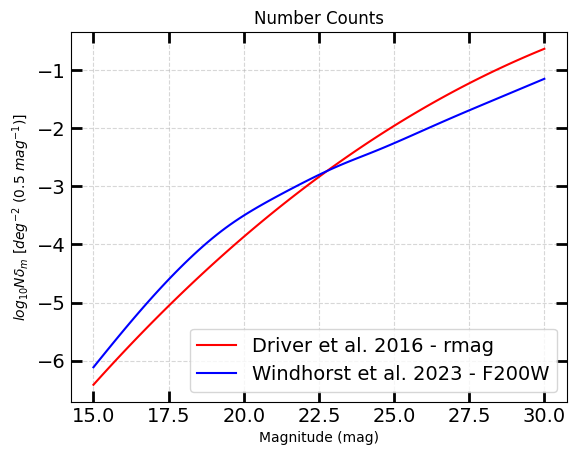

In [19]:
from scipy import interpolate
# Spline parameters(globals) are for rmag vs sigma
driver_tck = (np.array([15., 15., 15., 15., 30., 30., 30., 30.]),
       np.array([-6.41580144, -3.53188049, -1.68500105, -0.63090954, 0., 0., 0., 0.]), 3)
driver_spl = interpolate.UnivariateSpline._from_tck(driver_tck)



def driver_sigma(mag):
    """
    Estimated incidence of galaxies per sq arcsec with r > rmag
    using Driver et al. 2016 number counts.

    Spline parameters (globals) are for rmag vs sigma

    Args:
        rmag (float or np.ndarray): r band magnitude of galaxy

    Returns:
        float or np.ndarray:  Galaxy number density

    """
    return 10**driver_spl(mag)

# Test the function
mags = np.linspace(15., 30., 100)

fig, ax1 = plt.subplots()
ax1.plot(mags, np.log10(driver_sigma(mags)), label='Driver et al. 2016 - rmag', color='r')
ax1.plot(mags, np.log10(windhorst_sigma(mags)), label='Windhorst et al. 2023 - F200W', color='b') 
plt.xlabel('Magnitude (mag)')
plt.ylabel(r'$log_{10}N \delta_m$ [$deg^{-2}$ (0.5 $mag^{-1}$)]')
plt.title(r'Number Counts')
plt.grid(linestyle='--',alpha=0.5)
ax1.tick_params(axis='both', right=True, top=True, width=2, length=8, direction='in', which='both', labelsize=14)
ax1.legend(loc='lower right', fontsize=14)


In [10]:
# from scipy.interpolate import splrep, splev

# # Generate smooth points for plotting
# mag_fine = np.linspace(min(mag), max(mag), 200)
# N_spline = spline(mag_fine)

# # Save the spline coefficients (t, c, k) representation
# tck = splrep(mag, N, k=3, s=0)  # k=3 for cubic spline

# # Function to recreate the spline from saved coefficients
# def create_spline_from_tck(tck):
#     return UnivariateSpline._from_tck(tck)

# # Save coefficients for future use
# spline_tck = (tck[0], tck[1], tck[2])  # (knots, coefficients, degree)

# # Example of how to recreate the spline
# recreated_spline = create_spline_from_tck(spline_tck)

# # Testing the recreated spline with new data points
# N_recreated = recreated_spline(mag_fine)

# # Plot the recreated spline
# plt.figure(figsize=(8, 5))
# plt.scatter(mag, np.log10(N), color='red', label='Data Points')
# plt.plot(mag_fine, np.log10(N_recreated), label='Recreated Spline Fit', linewidth=2, linestyle='dashed')
# plt.xlabel('Magnitude (mag)')
# plt.ylabel('N')
# plt.title('Recreated Spline Fit from Saved Coefficients')
# plt.legend()
# plt.grid()
# plt.show()

# # Output the saved coefficients
# spline_tck
